Copyright (C) 2023 Glencoe Software, Inc. All Rights Reserved.

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.

### Supervised learning for HCS Assay with omero2pandas

This notebook demonstrates how to retrieve analytical data stored as an [OMERO.table](https://docs.openmicroscopy.org/omero-blitz/5.5.8/slice2html/omero/grid/Table.html) from the [OMERO.server](https://www.glencoesoftware.com/products/omeroplus/) using [omero2pandas](https://github.com/glencoesoftware/omero2pandas) and build unsupervised clustering model to profile the cells.

The example below uses the output of the image processing performed using [OMERO-Segmentation Connector for HCS](https://www.glencoesoftware.com/solutions/digital-pathology/) which utilizes [CellProfiler](https://github.com/stardist/stardist) as a segmenter. Derived features (parameters describing cells' shape, intensity and neighborhood) are then used to build a clustering model using [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html). Finally the cluster ids are assigned to each object and saved to [OMERO.tables](https://docs.openmicroscopy.org/omero-blitz/5.5.8/slice2html/omero/grid/Table.html) using [omero2pandas](https://github.com/glencoesoftware/omero2pandas). The stored data can be visualized remotely with [PathViewer](https://www.glencoesoftware.com/products/pathviewer/) and [Pageant](https://www.glencoesoftware.com/products/pageant/).

##### Workflow
 * Load OMERO.table to Pandas DataFrame using omero2pandas
 * Pre-process the data (replace missing values, normalize, etc.)
 * Remove strongly correlated features using Spearman correlation
 * Run dimensionality reduction using UMAP
 * Build an unsupervised clustering model and classify the cells
 * Visualize the results using Datashader, Bokeh, and HoloViews
 * Save the result to OMERO.tables for visualization with [PathViewer](https://www.glencoesoftware.com/products/pathviewer/) and [Pageant](https://www.glencoesoftware.com/products/pageant/), or other downstream workflows

#### Define variables and OMERO IDs that will be used for the next steps

In [1]:
# Define the image and table IDs
# Plate ID will be used to link the uploaded table to the image
PLATE_ID = 54
# Table IDs
METADATA_TABLE_FILE_ID = 18874
NUCLEI_TABLE_FILE_ID = 18865
CELLS_TABLE_FILE_ID = 18868
CYTOPLASM_TABLE_FILE_ID = 18869


# Where to store the downloaded table?
metadata_table_path = "./plate_metadata.csv"
nuclei_table = "./nuclei_table.csv"
cells_table = "./cells_table.csv"
cytoplasm_table = "./cytoplasm_table.csv"
# The name will be used as OMERO.table name
output_table_name = "Machine_learning_output"
# Store outputs locally
output_table_path = f"{output_table_name}.csv"

### Imports

In [9]:
%%capture
import logging
import os
import pandas as pd
import omero2pandas
from matplotlib import colors
from PIL import Image
from io import BytesIO
from omero.gateway import BlitzGateway
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gs_analytics
import numpy
from struct import unpack

## Data presentation

#### Human MCF7 and A549 cells cytoplasm–nucleus translocation

[BBBC014 Link](https://bbbc.broadinstitute.org/BBBC014)

##### Biological application

This 96-well plate has images of cytoplasm to nucleus translocation of the transcription factor NFκB in MCF7 (human breast adenocarcinoma cell line) and A549 (human alveolar basal epithelial) cells in response to TNFα concentration.

##### Images

Images are at 10x objective magnification. The plate was acquired at Vitra Bioscience on the CellCard reader. For each well there is one field with two images: a nuclear counterstain (DAPI) image and a signal stain (FITC) image. Image size is 1360 x 1024 pixels. Images are in 8-bit BMP format.

#### License

We used image set [BBBC014v1](https://bbbc.broadinstitute.org/bbbc/BBBC014) provided by Ilya Ravkin, available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012](http://dx.doi.org/10.1038/nmeth.2083).

#### Copyright

The SBS Bioimage CNT images are licensed under a [Creative Commons Attribution 3.0 Unported License](http://creativecommons.org/licenses/by/3.0/) by Ilya Ravkin.

### Let's have a look at the experimental layout

The plate map is stored in OMERO as [OMERO.table](https://docs.openmicroscopy.org/omero/5.6.3/developers/Tables.html).

Using [omero2pandas](https://docs.openmicroscopy.org/omero/5.6.3/developers/Tables.html) connector we're going to retrieve the table and create the concentration and cell type plots.

In [ ]:
# Initialize omero2pandas connector
connector = omero2pandas.connect_to_omero()

In [ ]:
# Load metadata and store it locally for now in case we want to work with it later
# or without server connection

if not os.path.exists(metadata_table_path):
    omero2pandas.download_table(
        metadata_table_path, file_id=METADATA_TABLE_FILE_ID, chunk_size=10000,
        omero_connector=connector)
else:
    print("File exists not downloading")

In [ ]:
df_metadata = pd.read_csv(metadata_table_path)
df_metadata.drop(columns=["Unnamed: 0"], inplace=True)
df_metadata.head()

In [ ]:
# Retreive plate layout from OMERO
def get_plate_layout(conn, plate_id):
    '''
    Build the plate grid from a Plate.
    '''
    # Request plate object.
    plate = conn.getObject("Plate", plate_id)
    # We'll use Plate's Well Grid to map Image Id
    # to a particular Row-Column Cell.
    wg = plate.getWellGrid()
    plate_layout = {}
    # Loop over all Rows and Columns and map the ImageIds.
    # For multiple fields this methods would have to be slightly modified.
    for x, row in enumerate(wg):
        for y, column in enumerate(row):
            for ws, well_sample in enumerate(column.getWellSamples()):
                image_id = well_sample.getImage().getId().val
                plate_layout[image_id] = [x, y]
    plate_layout["number_of_rows"] = len(wg)
    plate_layout["number_of_columns"] = len(wg[0])
    return plate_layout

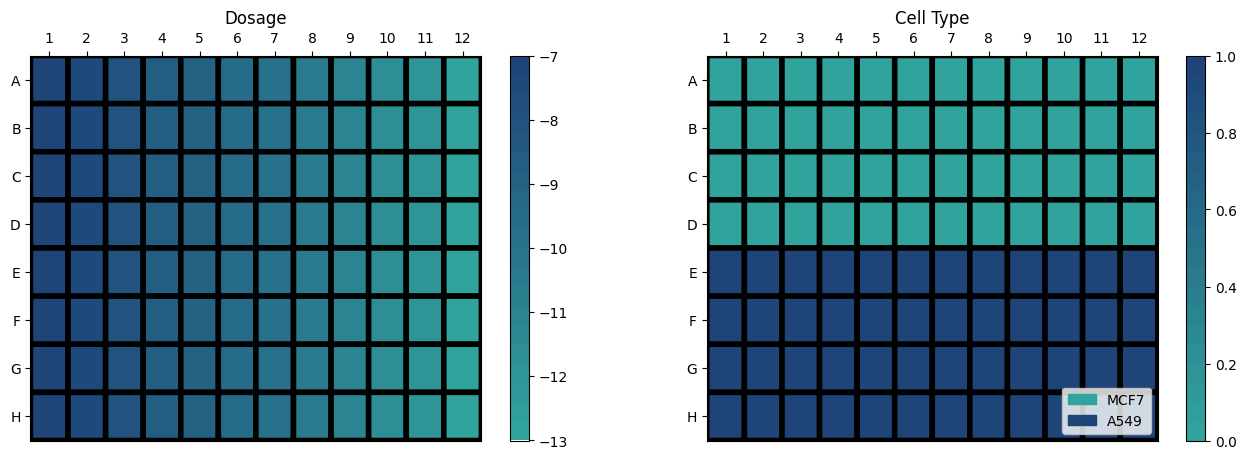

In [578]:
# Using df_metadata ceate concentration and cell type plots
# Dosage
plt.rcParams['figure.figsize'] = (16.0, 5.0)
plate_layout = get_plate_layout(conn, PLATE_ID)
image_ids = list(df_metadata["Image"])
dosage = list(df_metadata["Dose"])
dosage_display_matrix = gs_analytics.build_display_matrix(plate_layout, image_ids, dosage)

# Create custom color map
cmap = colors.ListedColormap([
    '#31A39Dff', '#309E9Bff', '#2F9999ff', '#2E9497ff', '#2D8F95ff',
    '#2C8A93ff','#2B8591ff','#2A808Fff','#297B8Dff','#28768Bff',
    '#27718Aff','#266C88ff','#256786ff','#246284ff','#235D82ff','#225880ff',
    '#21537Eff','#204E7Cff','#1F497Aff','#1E4478ff'
])

# Celltype
cell_type = list(df_metadata["Celltype"])
cell_type_dict = {"MCF7": 0, "A549": 1}
cell_type = [cell_type_dict[ct] for ct in cell_type]
celltype_display_matrix = gs_analytics.build_display_matrix(plate_layout, image_ids, cell_type)

# Create figure
fig = plt.figure()
# Add dosage
ax = fig.add_subplot(1, 2, 1)
im = ax.pcolor(dosage_display_matrix, cmap=cmap, edgecolors='k', linewidths=4)
gs_analytics.set_axis_properties(ax)
plt.title("Dosage")
plt.colorbar(im)
# Add Celltypes
ax = fig.add_subplot(1, 2, 2)
im = ax.pcolor(celltype_display_matrix, cmap=cmap, edgecolors='k', linewidths=4)
gs_analytics.set_axis_properties(ax)
plt.title("Cell Type")
plt.colorbar(im)
# Add legend with the mapping
plt.legend(handles=[
    mpatches.Patch(color='#31A39D', label='MCF7'),
    mpatches.Patch(color='#1E4478', label='A549')],
    loc='lower right')
plt.show()

#### Let's have a look at the images

In [560]:
# Connect to OMERO sever with BBBC014 dataset
from getpass import getpass
conn = BlitzGateway(
    input("Username: "), getpass("OMERO Password: "),
    host=input("Host: "), port=int(input("Port: ")))
conn.connect()

Username:  import.user
OMERO Password:  ········
Host:  apps.demo.omero-plus.io
Port:  4064


True

In [ ]:
# For all images in the metadata table load thumbnails
# Store the thumbnails in a dict

thumbnails = {}
for image_id in df_metadata["Image"].unique():
    image = conn.getObject("Image", image_id)
    thumbnails[image_id] = Image.open(BytesIO(image.getThumbnail(size=(256, 256))))

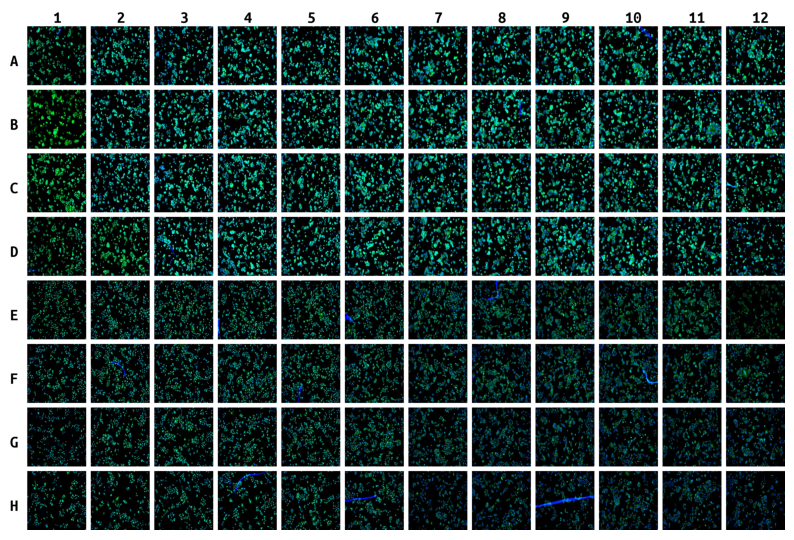

In [576]:
# Create a thumbnail montage from loaded images
# Read the first thumbnail and get the dimensions
thumbnail = thumbnails[list(thumbnails.keys())[0]]

# Create a new image with the size of the montage: 8 rows and 12 columns
# with 10 pixel padding between images
# Add extra space for label on the left and top
# Column labels are number based on the column number
# Row labels are letters based on the row number
padding = 20
montage = Image.new(
    mode="RGB",
    size=(75 + thumbnail.width * 12 + padding * 11, 75 + thumbnail.height * 8 + padding * 7),
    color=(255, 255, 255)
)

# Iterate over the thumbnails and paste them into the montage
for i, (image_id, thumbnail) in enumerate(thumbnails.items()):
    # Calculate the row and column of the thumbnail
    row = i // 12
    col = i % 12
    # Calculate the coordinates of the thumbnail
    x = 75 + col * (thumbnail.width + padding)
    y = 75 + row * (thumbnail.height + padding)
    # Paste the thumbnail into the montage
    montage.paste(thumbnail, box=(x, y))

# Add column and row labels
from PIL import ImageDraw, ImageFont

# Create a draw object
draw = ImageDraw.Draw(montage)
# Set font
font_type = ImageFont.truetype("/usr/share/fonts/truetype/ubuntu/UbuntuMono-B.ttf", size=72)
# Add column labels
for col in range(1, 13):
    # Calculate the coordinates of the top left corner of the label
    x = 50  + (col - 0.5) * (thumbnail.width + padding) 
    y = 0
    # Add the label
    draw.text((x, y), str(col), font=font_type, fill=(0, 0, 0))

# Add row labels
for row in range(1, 9):
    # Calculate the coordinates of the top left corner of the label
    x = 0
    y = 50 + (row - 0.5) * (thumbnail.height +  padding)
    # Add the label
    draw.text((x, y), chr(ord("A") + row - 1), font=font_type, fill=(0, 0, 0))

# Show the montage with matplotlib
plt.figure(figsize=(10, 14))
plt.imshow(montage)
plt.axis("off")
plt.show()

#### Image processing

All the above images were analyses using OMERO-CellProfiler Connector which allows to execute CellProfiler pipelines at scale in remote analysis environments like high performance computing cluset (HPC) or cloud batch infrastructure.

The results were save as OMERO.tables and associated with the plate.

**Let's retrieve the measurements** for Nuclei, Cytomplasm and Cells and find the Translocated and Untraslocated cell concentrations for each dose level of TNFα.

#### Load measurement tables

If [omero-user-token](https://github.com/glencoesoftware/omero-user-token) is installed and valid [omero2pandas](https://github.com/glencoesoftware/omero2pandas) will use it automatically for the OMERO.server connection otherwise it will ask for the connection details.

In [ ]:
# Tables can be loaded directly to Pandas DataFrames or stored locally
# In this case we're going to store them locally in case we need to work
# with them later with no Network connection

# Nuclei
if not os.path.exists(nuclei_table):
    omero2pandas.download_table(
        nuclei_table, file_id=NUCLEI_TABLE_FILE_ID, chunk_size=10000,
        omero_connector=connector)
else:
    print("File exists not downloading")

# Cytoplasm
if not os.path.exists(cytoplasm_table):
    omero2pandas.download_table(
        cytoplasm_table, file_id=CYTOPLASM_TABLE_FILE_ID, chunk_size=10000,
        omero_connector=connector)
else:
    print("File exists not downloading")

# Cells
if not os.path.exists(cells_table):
    omero2pandas.download_table(
        cells_table, file_id=CELLS_TABLE_FILE_ID, chunk_size=10000,
        omero_connector=connector)
else:
    print("File exists not downloading")

In [ ]:
# Load the tables
df_nuclei = pd.read_csv(nuclei_table)
df_nuclei.drop(columns=["Unnamed: 0"], inplace=True)
df_cytoplasm = pd.read_csv(cytoplasm_table)
df_cytoplasm.drop(columns=["Unnamed: 0"], inplace=True)
df_cells = pd.read_csv(cells_table)
df_cells.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
# Add "Nuclei_", "Cytoplasm_" and "Cells_" to the column names
# if column name is not ImageNumber of ObjectNumber
df_nuclei = df_nuclei.rename(columns={col: f"Nuclei_{col}" for col in df_nuclei.columns if col not in ["ImageNumber", "ObjectNumber"]})
df_cytoplasm = df_cytoplasm.rename(columns={col: f"Cytoplasm_{col}" for col in df_cytoplasm.columns if col not in ["ImageNumber", "ObjectNumber"]})
df_cells = df_cells.rename(columns={col: f"Cells_{col}" for col in df_cells.columns if col not in ["ImageNumber", "ObjectNumber"]})

In [ ]:
# Merge DataFrames on ImageNumber and ObjectNumber columns
df_measurements = df_nuclei.merge(df_cytoplasm, on=["ImageNumber", "ObjectNumber"])
df_measurements = df_measurements.merge(df_cells, on=["ImageNumber", "ObjectNumber"])
df_measurements.head()

In [ ]:
# Add dosage and CellType from df_metadata table
# Merge on ImageNumber
df_all = pd.merge(df_measurements, df_metadata, on='ImageNumber', how='left')
df_all.head()

In [577]:
len(df_all.columns)

135

### Supervised learning

* Train the classifier using untranslocated and translocated cells (scikit-learn)* 
Use the trained classifier to count the number of untranslocated and translocated cells at each doseage level (scikit-learn)

In [ ]:
# Create dataframe for each celltype
df_celltype = {}
for celltype in df_all['Celltype'].unique():
    df_celltype[celltype] = df_all[df_all['Celltype'] == celltype]
print(list(df_celltype.keys()))

In [ ]:
print(df_celltype["MCF7"]["Dose"].unique())

In [ ]:
positive_dose = -7.0
negative_dose = -13.0
label_values = [negative_dose, positive_dose]

label_column_name = "Dose"

In [ ]:
# Let's make the classfiers life a little bit easier
# and drop columns that represent metadata or spatial features

columns_to_drop = ['OMEROPlate', 'OMEROPlateId', 'WellLabel',
                    'OMEROWellId', 'PlateRow', 'PlateColumn', 'PlateField',
                    'ImageName', 'Image', 'ImageSeries',
                    'URL_GFP', 'Frame_GFP', 'URL_DNA', 'Frame_DNA', 'Celltype',
                    'Image Name']
cp_columns_to_drop = [
    'Nuclei_AreaShape_BoundingBoxArea',
    'Nuclei_AreaShape_BoundingBoxMaximum_X', 'Nuclei_AreaShape_BoundingBoxMaximum_Y',
    'Nuclei_AreaShape_BoundingBoxMinimum_X', 'Nuclei_AreaShape_BoundingBoxMinimum_Y',
    'Nuclei_AreaShape_Center_X', 'Nuclei_AreaShape_Center_Y',
    'Nuclei_Children_Cells_Count', 'Nuclei_Children_Cytoplasm_Count',
    'Nuclei_Location_Center_X', 'Nuclei_Location_Center_Y', 'Nuclei_Location_Center_Z',
    'Nuclei_Location_MaxIntensity_X_DNA', 'Nuclei_Location_MaxIntensity_Y_DNA', 'Nuclei_Location_MaxIntensity_Z_DNA',
    'Nuclei_Number_Object_Number',
    'Cytoplasm_Location_Center_X', 'Cytoplasm_Location_Center_Y', 'Cytoplasm_Number_Object_Number',
    'Cytoplasm_Parent_Cells', 'Cytoplasm_Parent_Nuclei',
    'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X',
    'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X',
    'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y',
    'Cells_Children_Cytoplasm_Count', 'Cells_Location_Center_X', 'Cells_Location_Center_Y',
    'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_GFP', 'Cells_Location_MaxIntensity_Y_GFP',
    'Cells_Location_MaxIntensity_Z_GFP', 'Cells_Number_Object_Number', 'Cells_Parent_Nuclei'
]

### Train the classifier

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import sklearn.svm as svm
from sklearn.preprocessing import StandardScaler

In [ ]:
def train_with_feature_selection(x, y):
    '''
    Train the classifier with the feature selection.
    '''
    etc = LinearSVC(penalty="l1", dual=False)
    etc = etc.fit(x, y)
    model = SelectFromModel(etc, prefit=True)
    x_new = model.transform(x)
    print(f"Selected {x_new.shape[1]} features using the linear SVC model.")
    clf = svm.SVC(kernel='linear', C=1, probability=True)
    print("    Fitting...")
    clf.fit(x_new, y)
    print("    Done")
    return {'clf': clf, 'model': model}

In [ ]:
# Create new df for each celltype and drop columns that are not needed
df_celltype_analytics = {}
for celltype in df_celltype.keys():
    df_celltype_analytics[celltype] = df_celltype[celltype].drop(columns=columns_to_drop)
    df_celltype_analytics[celltype] = df_celltype_analytics[celltype].drop(columns=cp_columns_to_drop)

# For each celltype train the classifier
# Select the rows for positive and negative dose
# Train the classifier
# Store the classifier in a dict
classifiers = {}
for celltype in df_celltype_analytics.keys():
    df_temp = df_celltype_analytics[celltype]
    df_positive = df_temp[df_temp[label_column_name] == positive_dose]
    df_negative = df_temp[df_temp[label_column_name] == negative_dose]
    df_temp = pd.concat([df_positive, df_negative])
    # Print number of rows for each dose
    print(f"Celltype: {celltype}")
    print(f"Positive dose: {len(df_positive)}")
    print(f"Negative dose: {len(df_negative)}")
    print(f"Total: {len(df_temp)}")
    # Train the classifier
    print(df_positive["ImageNumber"].unique())
    print(df_negative["ImageNumber"].unique())
    x = df_temp.drop(columns=[label_column_name, "ImageNumber", "ObjectNumber"])
    y = df_temp[label_column_name]
    classifiers[celltype] = train_with_feature_selection(x, y)

Celltype: MCF7
Positive dose: 2948
Negative dose: 2851
Total: 5799
[12 24 36 48]
[ 1 13 25 37]


/root/root.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/root/root.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected 47 features using the linear SVC model.
    Fitting...


### Classify objects in all images

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create a new dataframe with the following columns:
# ImageNumber, CellType, Dose, Positive, Negative
df_predictions = pd.DataFrame(
    columns=[
        "ImageNumber", "CellType", "Dose", "Positive",
        "Negative", "Positive%", "Negative%"])

# Get probabilities for each object and store them in a new dataframe
df_probabilities = pd.DataFrame(
    columns=[
        "ImageNumber", "ObjectNumber", "CellType", "Dose",
        "Probability Positive", "Probability Negative", "Label"])
for celltype in df_celltype_analytics.keys():
    for dose in df_celltype[celltype][label_column_name].unique():
        print(f"Dose: {dose}")
        # Iterate over the images
        df = df_celltype_analytics[celltype]
        image_numbers = df[df[label_column_name] == dose]["ImageNumber"].unique()
        print(f"Images: {image_numbers}")
        for image_number in image_numbers:
            # Find the number of positive and negative cells in each image
            df_temp = df[(df[label_column_name] == dose) & (df["ImageNumber"] == image_number)]
            x = df_temp.drop(columns=[label_column_name, "ImageNumber", "ObjectNumber"])
            y = df_temp[label_column_name]
            # Predict
            x_new = classifiers[celltype]["model"].transform(x)
            y_conf = classifiers[celltype]["clf"].predict_proba(x_new)
            y_pred = classifiers[celltype]["clf"].predict(x_new)
            # Store the probabilities and predictions
            for i, object_number in enumerate(df_temp["ObjectNumber"]):
                df_probabilities = df_probabilities.append({
                    "ImageNumber": image_number,
                    "ObjectNumber": object_number,
                    "CellType": celltype,
                    "Dose": dose,
                    "Probability Positive": y_conf[i][0],
                    "Probability Negative": y_conf[i][1],
                    "Label": y_pred[i]
                }, ignore_index=True)
            # Count the number of positive and negative cells
            positive = len(y_pred[y_pred == positive_dose])
            negative = len(y_pred[y_pred == negative_dose])
            negative_per = negative/(negative + positive)
            positive_per = positive/(negative + positive)
            # Add the row to the dataframe
            # Add the row to the dataframe
            print(
                f"ImageNumber: {image_number}, CellType: {celltype}, Dose: {dose}, Positive: {positive_per}, Negative: {negative_per}"
            )
            df_predictions = df_predictions.append({
                "ImageNumber": image_number,
                "CellType": celltype,
                "Dose": dose,
                "Positive": positive,
                "Negative": negative,
                "Positive%": positive_per,
                "Negative%": negative_per
            }, ignore_index=True)

In [ ]:
df_probabilities.head()

#### Let's create a chart that will show cell label proportions for each cell type

In [ ]:
# Plot the results
# Create a new dataframe with the following columns:

df_result = pd.DataFrame(columns=["CellType", "Dose", "Positive", "Negative", "Positive%", "Negative%"])
for celltype in df_predictions["CellType"].unique():
    for dose in df_predictions["Dose"].unique():
        df_temp = df_predictions[(df_predictions["CellType"] == celltype) & (df_predictions["Dose"] == dose)]
        positive = df_temp["Positive"].sum()
        negative = df_temp["Negative"].sum()
        negative_per = negative/(negative + positive)
        positive_per = positive/(negative + positive)
        df_result = df_result.append({
            "CellType": celltype,
            "Dose": dose,
            "Positive": positive,
            "Negative": negative,
            "Positive%": positive_per,
            "Negative%": negative_per
        }, ignore_index=True)
print(df_result.head())

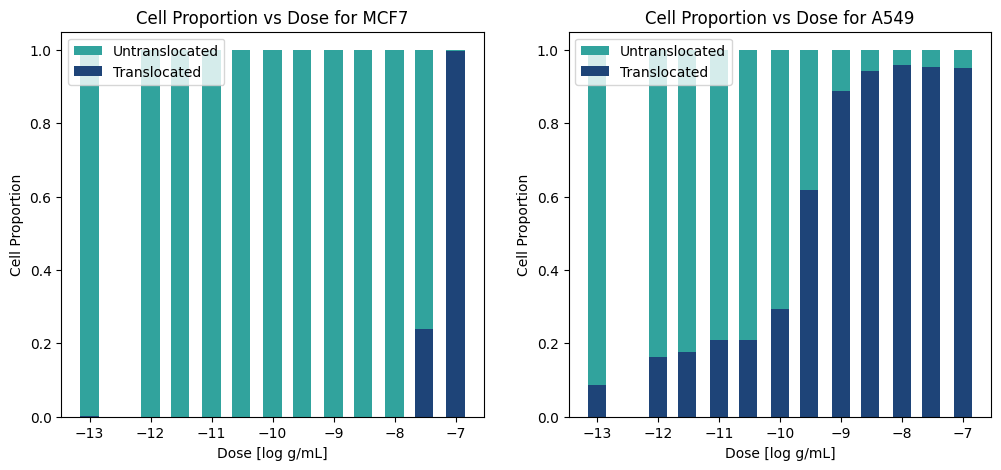

In [575]:
# Create figure
fig = plt.figure()

# Iterate over the celltypes
for i, celltype in enumerate(df_result["CellType"].unique()):
    ax = fig.add_subplot(1, 2, i + 1)
    df_temp = df_result[df_result["CellType"] == celltype]
    
    # Stack negative on top of positive
    ax.bar(df_temp["Dose"], df_temp["Positive%"], 0.3, bottom=df_temp["Negative%"], label=f"Untranslocated", color="#31A39D")
    ax.bar(df_temp["Dose"], df_temp["Negative%"], 0.3, label=f"Translocated", color="#1E4478")
    # Set axis properties
    ax.set_xlabel("Dose [log g/mL]")
    ax.set_ylabel("Cell Proportion")
    ax.set_title(f"Cell Proportion vs Dose for {celltype}")
    ax.legend()
plt.show()

### Let's look at some examples of Translocated and Untranslocated Cells

In [570]:
# Define required functions

PIXEL_TYPES = {
    "int8": ['b', numpy.int8],
    "uint8": ['B', numpy.uint8],
    "int16": ['h', numpy.int16],
    "uint16": ['H', numpy.uint16],
    "int32": ['i', numpy.int32],
    "uint32": ['I', numpy.uint32],
    "float": ['f', numpy.float64],
    "double": ['d', numpy.double]}

def load_image(channel_list, rps, pixel_type, width, height):
    image_pixels = np.zeros((plane_y, plane_x, 3), dtype=np.uint8)
    for c in channel_list:
        plane_bytes = rps.getPlane(0, c, 0)
        numpy_type = PIXEL_TYPES[pixel_type][1]
        convert_types = '>%d%s' % ((height * width), PIXEL_TYPES[pixel_type][0])
        converted_plane = unpack(convert_types, plane_bytes)
        # Convert to numpy array
        plane = np.array(converted_plane, dtype=numpy_type)
        # Reshape to 2D
        plane = plane.reshape((height, width))
         # Adjust intensity range
        plane = plane.astype(np.float32)
        plane = plane - plane.min()
        plane = plane / plane.max()
        plane = plane * 255
        plane = plane.astype(np.uint8)
        # Add to numpy image
        if c == 0:
            image_pixels[:, :, 1] = plane
        if c == 1:
            image_pixels[:, :, 2] = plane
    return image_pixels

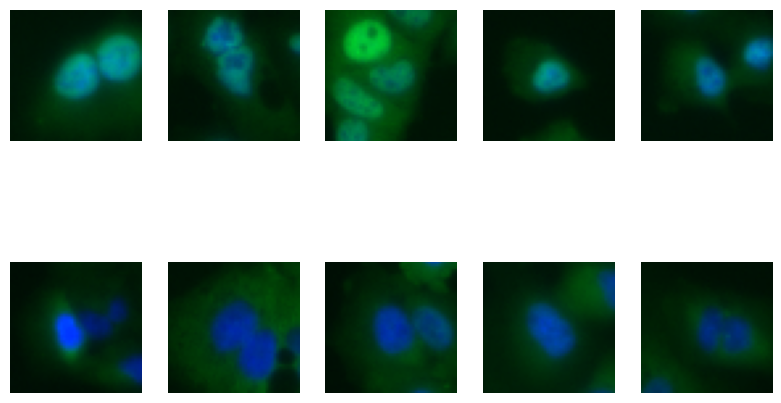

In [574]:
# Get 5 random cells for positive_dose and negative_dose
# Load and render an image from OMERO and cut out the cells with 50 x 50 pixel window
df_positive = df_probabilities[(df_probabilities["CellType"] == "A549") & (df_probabilities["Label"] == positive_dose)].sample(5)
df_negative = df_probabilities[df_probabilities["Label"] == negative_dose].sample(5)

# Get image id for each object from df_all
positive_image_info = []
nagative_image_info = []
for i in range(5):
    image_number, object_number = df_negative[["ImageNumber", "ObjectNumber"]].iloc[i]
    nagative_image_info.append((image_number, object_number))
    image_number, object_number = df_positive[["ImageNumber", "ObjectNumber"]].iloc[i]
    positive_image_info.append((image_number, object_number))

positive_cells = list()
for image_number, object_number in positive_image_info:
    image_id = df_all[df_all["ImageNumber"] == image_number]["Image"].unique()[0]
    object_location = df_all[
        (df_all["ImageNumber"] == image_number) & (df_all["ObjectNumber"] == object_number)][
        ["Nuclei_Location_Center_X", "Nuclei_Location_Center_Y"]].values[0]
    image = conn.getObject("Image", image_id)
    # Get the pixels
    pixels = image.getPrimaryPixels()
    pixel_type = pixels.getPixelsType().value
    rps = conn.createRawPixelsStore()
    ctx = {'omero.group': str(pixels.getDetails().getGroup().id)}
    rps.setPixelsId(pixels.getId(), False, ctx)
    resolutions = rps.getResolutionDescriptions()
    rps.setResolutionLevel(len(resolutions) - 1)
    plane_x = resolutions[0].sizeX
    plane_y = resolutions[0].sizeY
    # Define image numpy array
    image_pixels = load_image([0, 1], rps, pixel_type, plane_x, plane_y)
    rps.close()
    # Get the window
    positive_cells.append(image_pixels[int(object_location[1]) - 25:int(object_location[1]) + 25, int(object_location[0]) - 25:int(object_location[0]) + 25, :])

nagative_cells = list()
for image_number, object_number in nagative_image_info:
    image_id = df_all[df_all["ImageNumber"] == image_number]["Image"].unique()[0]
    object_location = df_all[
        (df_all["ImageNumber"] == image_number) & (df_all["ObjectNumber"] == object_number)][
        ["Nuclei_Location_Center_X", "Nuclei_Location_Center_Y"]].values[0]
    image = conn.getObject("Image", image_id)
    # Get the pixels
    pixels = image.getPrimaryPixels()
    pixel_type = pixels.getPixelsType().value
    rps = conn.createRawPixelsStore()
    ctx = {'omero.group': str(pixels.getDetails().getGroup().id)}
    rps.setPixelsId(pixels.getId(), False, ctx)
    resolutions = rps.getResolutionDescriptions()
    rps.setResolutionLevel(len(resolutions) - 1)
    plane_x = resolutions[0].sizeX
    plane_y = resolutions[0].sizeY
    # Define image numpy array
    image_pixels = load_image([0, 1], rps, pixel_type, plane_x, plane_y)
    rps.close()
    # Get the window
    nagative_cells.append(image_pixels[int(object_location[1]) - 25:int(object_location[1]) + 25, int(object_location[0]) - 25:int(object_location[0]) + 25, :])

# Create 5 panel figure
fig = plt.figure(figsize=(20, 12))
for i, cell_image in enumerate(nagative_cells):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(cell_image)
    ax.axis("off")
    ax.title("Untranslocted Cells")
for i, cell_image in enumerate(positive_cells):
    ax = fig.add_subplot(2, 10, i + 1)
    ax.imshow(cell_image)
    ax.axis("off")
    ax.title("Transolcated Cells")
plt.show()

#### Save the result as new OMERO.table


In [ ]:
for celltype in df_reduced_labels.keys():
    df_reduced_labels[celltype]['Cluster'] = clusters[celltype]
    # Upload the table to OMERO
    ann_id = omero2pandas.upload_table(
        df_reduced_labels[celltype], output_table_name,
        PLATE_ID, "Plate", chunk_size=10000)
    print(f"Uploaded table with ID: {ann_id}")